# **TRABAJANDO CON KERNELS**

· PABLO MENDIETA RUIZ 

· 09 / 10 / 2024 

## **Carga de la base de Datos**

In [27]:
# Importación de todas las librerias necesarias 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [28]:
# Cargar el conjunto de datos Iris
iris = datasets.load_iris()

# Convertir a DataFrame para mayor flexibilidad
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

df = df[['sepal length (cm)', 'sepal width (cm)', 'target']]

# Eliminar una de las clases 
df = df[df['target'] != 2]

# Separar características (X) y etiquetas (y)
X = df.drop('target', axis=1)
y = df['target']

# Dividir en conjuntos de entrenamiento y prueba (80% para entrenamiento)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos usando MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Imprimir la forma de los conjuntos
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')
print(f'Tamaño de las etiquetas de entrenamiento: {y_train.shape}')
print(f'Tamaño de las etiquetas de prueba: {y_test.shape}')

Tamaño del conjunto de entrenamiento: (80, 2)
Tamaño del conjunto de prueba: (20, 2)
Tamaño de las etiquetas de entrenamiento: (80,)
Tamaño de las etiquetas de prueba: (20,)


In [29]:
# Función para graficar la clasificación
def graficar_clasificacion(modelo, X, y, titulo, kernel_fn):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', s=30)
    
    # Crear una malla para el contorno
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                         np.linspace(ylim[0], ylim[1], 100))
    
    # Precomputar el kernel para la malla
    X_mesh = np.c_[xx.ravel(), yy.ravel()]
    kernel_mesh = kernel_fn(X_mesh, X)
    
    Z = modelo.decision_function(kernel_mesh)
    Z = Z.reshape(xx.shape)

    # Dibujar el contorno y los márgenes
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.7,
               linestyles=['--', '-', '--'])

    # Dibujar los vectores soporte
    ax.scatter(X[:, 0], X[:, 1], s=100, linewidth=1,
               facecolors='none', edgecolors='k')

    plt.title(titulo)
    plt.show()

Creación del Kernel Lineal 

In [49]:
def calculator_kernel(X, Y):
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(Y, pd.DataFrame):
        Y = Y.values
    
    n_samples_1, n_features = X.shape
    n_samples_2 = Y.shape[0]
    kernel_matrix = np.zeros((n_samples_1, n_samples_2))
    
    for i in range(n_samples_1):
        for j in range(n_samples_2):
            dot_product = 0
            for k in range(n_features):
                dot_product += X[i, k] * Y[j, k]
            kernel_matrix[i, j] = dot_product
            
    return kernel_matrix

# Calcular el kernel
kernel_train = calculator_kernel(X_train, X_train)
kernel_test = calculator_kernel(X_test, X_train)



# Entrenar SVM con kernel lineal precomputado
svm_lineal = svm.SVC(kernel='precomputed')
svm_lineal.fit(kernel_train, y_train)

# Calcular la matriz del kernel para el conjunto de test
kernel_test = calculator_kernel(X_test, X_train)

# Predecir las etiquetas del conjunto de test usando el modelo entrenado
y_pred = svm_lineal.predict(kernel_test)

# Calcular la suma de errores absolutos
suma_errores_absolutos = np.sum(np.abs(y_test - y_pred))

# Calcular el accuracy usando la suma de errores absolutos
n_samples = len(y_test)
accuracy_absoluta = 1 - (suma_errores_absolutos / n_samples)

print(f'Suma de errores absolutos: {suma_errores_absolutos}')
print(f'Accuracy usando suma de errores absolutos: {accuracy_absoluta}')


Suma de errores absolutos: 0
Accuracy usando suma de errores absolutos: 1.0


Creación del Kernel con una Transformación 

In [31]:

def transformacion(x):
    """
    Aplica transformaciones no lineales complejas al vector x.
    Combina funciones trigonométricas, exponenciales y operaciones de interacción.
    """
    # Crear nuevas coordenadas aplicando transformaciones no lineales complejas
    nuevas_coordenadas = []
    for elemento in x:
        nuevas_coordenadas.append(np.sin(elemento) * np.cos(elemento))  # Producto seno-coseno
        nuevas_coordenadas.append(np.exp(-elemento))                    # Exponencial negativa
        nuevas_coordenadas.append(elemento ** 2)                        # Cuadrado
        nuevas_coordenadas.append(np.sqrt(np.abs(elemento)))            # Raíz cuadrada del valor absoluto
        nuevas_coordenadas.append(np.tanh(elemento))                    # Función tangente hiperbólica
        nuevas_coordenadas.append(np.log(np.abs(elemento) + 1))         # Logaritmo natural con desplazamiento para evitar log(0)
    
    # Agregar interacciones entre los elementos originales
    interacciones = []
    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            interacciones.append(x[i] * x[j])                          # Producto entre pares de elementos
    
    # Concatenar el vector original con las nuevas coordenadas y las interacciones
    x_transformado = np.concatenate([x, nuevas_coordenadas, interacciones])
    
    return x_transformado


def calculator_kernel(X, Y):
    # Inicializar la matriz del kernel polinómico
    kernel_matrix = []

    # Recorrer cada fila de X
    for x in X:
        row_result = []
        # Recorrer cada fila de Y
        for y in Y:
            # Calcular el producto ESCALAR punto entre x e y
            dot_product = 0
            
            for x_i, y_i in zip(transformacion(x), transformacion(y)):
                dot_product += x_i * y_i
            row_result.append(dot_product)
        kernel_matrix.append(row_result)

    return np.array(kernel_matrix)


# Calcular el kernel
kernel_train = calculator_kernel(X_train, X_train)
kernel_test = calculator_kernel(X_test, X_train)

# Precomputar los kernels
kernel_l = calculator_kernel(X_train, X_train)


# Entrenar SVM con kernel lineal precomputado
svm_lineal = svm.SVC(kernel='precomputed')
svm_lineal.fit(kernel_l, y_train[:100])

from sklearn.metrics import accuracy_score

# Calcular la matriz del kernel para el conjunto de test
kernel_test = calculator_kernel(X_test, X_train)

# Predecir las etiquetas del conjunto de test usando el modelo entrenado
y_pred = svm_lineal.predict(kernel_test)

# Calcular el accuracy comparando las etiquetas predichas con las reales
accuracy = accuracy_score(y_test[:100], y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


Creación del Kernel NO lineal 

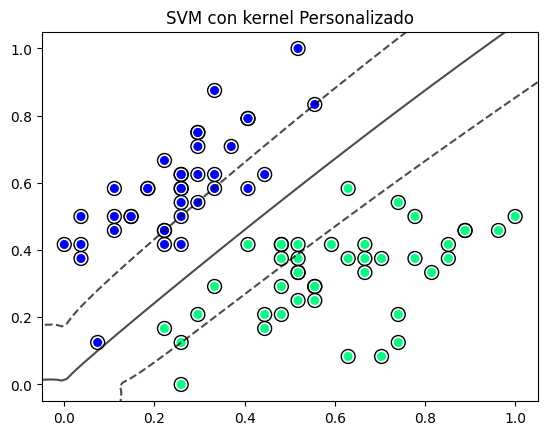

In [32]:
# Graficar la clasificación para el kernel personalizado
graficar_clasificacion(svm_lineal, X_train, y_train[:100], "SVM con kernel Personalizado", calculator_kernel)

In [33]:

# Función para calcular el kernel usando logaritmos
def calculator_kernel_no_lineal(X1, X2):
    if isinstance(X1, pd.DataFrame):
        X1 = X1.values
    if isinstance(X2, pd.DataFrame):
        X2 = X2.values
    
    n_samples_1, n_features = X1.shape
    n_samples_2 = X2.shape[0]
    kernel_matrix = np.zeros((n_samples_1, n_samples_2))
    
    for i in range(n_samples_1):
        for j in range(n_samples_2):
            dot_product = 0
            for k in range(n_features):
                dot_product += np.log1p(X1[i, k]) * np.log1p(X2[j, k])  # Usar logaritmos
            kernel_matrix[i, j] = dot_product
            
    return kernel_matrix

# Calcular el kernel
kernel_train_no_lineal = calculator_kernel_no_lineal(X_train, X_train)
kernel_test_no_lineal = calculator_kernel_no_lineal(X_test, X_train)


## Pruebas de los kernels con el modelo SVC

In [34]:
# Crear el modelo SVC con kernel precomputado
svc_model = SVC(kernel='precomputed')

# Entrenar el modelo
svc_model.fit(kernel_train, y_train)

# Predecir con el kernel precomputado
y_pred = svc_model.predict(kernel_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo SVC con kernel lineal: {accuracy:.4f}")

Precisión del modelo SVC con kernel lineal: 1.0000


In [35]:
# Crear el modelo SVC con kernel precomputado
svc_model = SVC(kernel='precomputed')

# Entrenar el modelo
svc_model.fit(kernel_train_no_lineal, y_train)

# Predecir con el kernel precomputado
y_pred = svc_model.predict(kernel_test_no_lineal)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo SVC con kernel personalizado: {accuracy:.4f}")

Precisión del modelo SVC con kernel personalizado: 1.0000
